### Demo na konferencję EuroHPC (case z kodowaniem binarnym i z QAOA) - draft
DO ZMIANY: opis 
We will focus on the following workflow instance (for now, in the simplified problem, we will not use the Workflow or WorkflowSchedulingProblem classes, because we want to test the Unbalanced Penalization method https://arxiv.org/pdf/2211.13914.pdf), which is not included in QHyper. But I will leave it here just for reference (especially for observation of what data is in the time and cost matrices).

In [1]:
import sys
sys.path.append("..")
from QHyper.problems.workflow_scheduling import (
    Workflow,
    WorkflowSchedulingBinary
)

tasks_file =  "workflows_data/workflows/3_tasks_4_machines_1_path.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_4_machines_1_path.json"
deadline = 13

workflow = Workflow(tasks_file, machines_file, deadline)
problem = WorkflowSchedulingBinary(workflow)


In [2]:
problem.workflow.cost_matrix


,MachineA,MachineB,MachineC,MachineD
task1,6.0,8.0,8.0,2.0
task2,3.0,4.0,4.0,1.0
task3,12.0,16.0,16.0,4.0


Uwaga: tutaj tak naprawdę jest dodana jeszcze jedna maszyna (liczba maszyn musi być 2^n)

In [3]:
problem.workflow.time_matrix


,MachineA,MachineB,MachineC,MachineD
task1,6.0,2.0,4.0,16.0
task2,3.0,1.0,2.0,8.0
task3,12.0,4.0,8.0,32.0


Below is the list of the hyperparameters (weights) that can be changed.  I assumed that the weights hyper_b, hyper_c, hyper_d can be the same, since the constraint they represent has a very similar form.

In [4]:
hyper_params = {'cost_function_weight': 1, # weight for: cost function
               'deadline_linear_form_weight': 2, # weight for: deadline constraint - linear form (-- this is from the unbalanced penalization approach)
                'deadline_quadratic_form_weight': 2} # weight for: deadline constraint - quadratic form


 DO ZMIANY: generacja tych wzorów z WFCommons

In [5]:
print(f"Variables used to describe objective function"
      f" and constraints: {problem.variables}")
print(f"Objective function: {problem.objective_function}")
print("Constraints (RHS == 0):")
for constraint in problem.constraints:
    print(f"    {constraint}")


Variables used to describe objective function and constraints: (x0, x1, x2, x3, x4, x5)
Objective function: {('x0', 'x1'): -8.0, ('x0',): 2.0, ('x1',): 2.0, ('x2', 'x3'): -4.0, ('x2',): 1.0, ('x3',): 1.0, ('x4', 'x5'): -16.0, ('x4',): 4.0, ('x5',): 4.0, (): 21.0}
Constraints (RHS == 0):
    {('x0', 'x1'): 16.0, ('x0',): -2.0, ('x1',): -4.0, ('x2', 'x3'): 8.0, ('x2',): -1.0, ('x3',): -2.0, ('x4', 'x5'): 32.0, ('x4',): -4.0, ('x5',): -8.0, (): 21.0} <= 13


# 3 Using QHyper

Do zmiany - konfiguracja wag

In [6]:
import numpy as np
params_config = {
        'angles': [[0.1e-13]*6, [np.pi/2]*6], # QAOA angles - first we have gammas (for the cost Hamiltonian), then we have betas (for the mixer)
        'hyper_args': [hyper_params['cost_function_weight'],
                       hyper_params['deadline_linear_form_weight'],
                       hyper_params['deadline_quadratic_form_weight']
                       ],
    }


In [10]:
# Create a VQA instance with QAOA as PQC and scipy optimizer
# This can be done in two various way
# 1. Providing dict with config (usefull to save experiment confing in e.g JSON)
# DO ZMIANY sqaoa -> qaoa (backend= "default.qubit") oraz QNG optimiser (krok 0.0001) 50 krokow
from QHyper.solvers import VQA, solver_from_config

solver_config = {
    "solver": {
        "type": "vqa",
        "pqc": {
            "type": "qml_qaoa",
            "layers": 6,
            "optimizer": "qng",
            "optimizer_args": {
                "stepsize": 0.00045,
                "steps": 50,
                "verbose": True,
            },
            "backend": "default.qubit",
        },
        "params_inits": params_config
    },
    "problem": {
        "type": "workflow_scheduling",
        "encoding": "binary",
        "tasks_file": tasks_file,
        "machines_file": machines_file,
        "deadline": deadline,
    }
}

vqa = solver_from_config(solver_config)


In [11]:
solver_results = vqa.solve()


Step 1/1: 612.9999999999897


In [9]:
print(f"Best params: {solver_results.params}")


Best params: {'angles': tensor([[ 3.16563674e-04,  6.74907789e-04, -1.05995569e-03,
         -6.53432898e-04, -8.83401418e-04, -1.17955917e-03],
        [-3.30431302e+02, -3.68020049e+01, -3.34198162e+01,
         -1.14607516e+02, -1.73274107e+02, -1.30915143e+02]], requires_grad=True), 'hyper_args': tensor([1, 2, 2], requires_grad=True)}


In [10]:
from QHyper.util import (
    weighted_avg_evaluation, sort_solver_results, add_evaluation_to_results)

# Evaluate results with weighted average evaluation
print("Evaluation:")
print(weighted_avg_evaluation(
    solver_results.results_probabilities, problem.get_score,
    penalty=0, limit_results=20, normalize=True
))
print("Sort results:")
sorted_results = sort_solver_results(
    solver_results.results_probabilities, limit_results=20)

# Add evaluation to results
results_with_evaluation = add_evaluation_to_results(
    sorted_results, problem.get_score, penalty=0)

for result, (probability, evaluation) in results_with_evaluation.items():
    print(f"Result: {result}, "
          f"Prob: {probability:.5}, "
          f"Evaluation: {evaluation}")


Evaluation:
3.051823527888819
Sort results:
Result: 000000, Prob: 0.21114, Evaluation: 0
Result: 000100, Prob: 0.074346, Evaluation: 0
Result: 000010, Prob: 0.073985, Evaluation: 0
Result: 001000, Prob: 0.071836, Evaluation: 0
Result: 000001, Prob: 0.048846, Evaluation: 25.0
Result: 110000, Prob: 0.035693, Evaluation: 0
Result: 100100, Prob: 0.024409, Evaluation: 0
Result: 101000, Prob: 0.024142, Evaluation: 0
Result: 110010, Prob: 0.019189, Evaluation: 0
Result: 001010, Prob: 0.019118, Evaluation: 0
Result: 000110, Prob: 0.018114, Evaluation: 0
Result: 010100, Prob: 0.016495, Evaluation: 0
Result: 011000, Prob: 0.01556, Evaluation: 0
Result: 110001, Prob: 0.013899, Evaluation: 0
Result: 011010, Prob: 0.013008, Evaluation: 28.0
Result: 111000, Prob: 0.012825, Evaluation: 0
Result: 010010, Prob: 0.012311, Evaluation: 27.0
Result: 010110, Prob: 0.012198, Evaluation: 28.0
Result: 110100, Prob: 0.011651, Evaluation: 0
Result: 101010, Prob: 0.011545, Evaluation: 0


<AxesSubplot: xlabel='index', ylabel='value'>

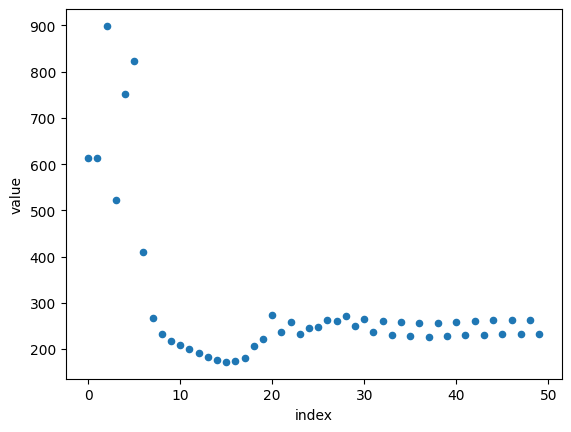

In [11]:
import pandas as pd

pd.DataFrame(solver_results.history[0]).reset_index().plot(x='index',y='value', kind='scatter')
